# IMPORTING THE LIBRARIES

In [17]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import random
%matplotlib inline
import tensorflow as tf
import glob
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# DEFINING THE IDENTITY BLOCK

The identity block contains main layers executed in the algorithm.

Algorithm consists of 3 parts.

Each part consists of:
    1. Convolutional2D
    2. Batch normalization
    3. Activation function

At the end, the layers are added to each other:
    
    X_shortcut has the weights of input data layer.
    X in the end consists of the weights of data passed through all those parts.
    
    By adding those 2 layers will give an output.

In [18]:
def identity_block(X,f,filters,stage,block):
    X_shortcut = X
    F1,F2,F3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    #1st part of main block
    X = Conv2D(F1, kernel_size=(1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    #2nd part of the main block
    X = Conv2D(F2, kernel_size=(f,f), strides = (1,1), padding ='same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3 , name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    #3rd part of the main block
    X = Conv2D(F3, kernel_size = (1,1), strides = (1,1), padding =  'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0) )(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    #Adding the layer
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

# DEFINING THE CONVOLUTIONAL BLOCK

The convolutional block is used to match the shape of input with output

Convolution block consists of 5 parts:
    3 parts of the block consists:
        1. Convolution2D
        2. Batch normalization
        3. Activation
        
    In remaining 2 parts:
        One of them is the shortcut path which replicates the "Skip Connections".
        Last one add the layers:
            1. The output of the input data from 1st three parts.
            2. The output of the "Skip Connections" part.

In [19]:
def convolutional_block(X,f,filters,stage,block,s = 2):
    X_shortcut = X
    F1,F2,F3 = filters
    conv_name_base = 'res'+str(stage) + block +'_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # 1st block of the main part
    X = Conv2D(F1, kernel_size= (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0) )(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # 2nd block of the main part
    X = Conv2D(F2, kernel_size= (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0) )(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    #3rd block of the main part
    X = Conv2D(F3, kernel_size= (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0) )(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    # Shortcut block
    X_shortcut = Conv2D(F3, kernel_size= (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed = 0) )(X_shortcut)
    X = BatchNormalization(axis = 3, name = bn_name_base + '1')(X)
    
    # Add the layers
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

# REPLICATING THE RESNET USING IDENTITY AND CONVOLUTIONAL BLOCKS

In the below code the entire Resnet is replicated using "Identity block" and "Convolutional block".

Firstly the data is padding with size 3.Then the blocks are defined.

The resnet consists of 5 stages:
    In the first stage, it consists:
        
        1. Convolutional layer.
        2. Batch normalization.
        3. Activation.
        4. Max pooling.
        
    In the second stage, it consists:
        1 convolutional block and 2 identity blocks
        
    In the third stage, it consists:
        1 Convolutional block and 3 Identity blocks
        
    In the fourth stage, it consists:
        1 Convolutional block and 5 Identity block.
    
    In the fifth stage, it consists:
        1 Convolutional block and 2 Identity blocks
        
    In the last/ Output layer, it consists:
        
        1. Average pooling
        2. Flatten
        3. Dense layers.

In [20]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 2):
   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X,f =3,filters = [128,128,512],stage = 3,block ='a',s =2)
    X = identity_block(X,3,[128,128,512],stage=3,block='b')
    X = identity_block(X,3,[128,128,512],stage=3,block='c')
    X = identity_block(X,3,[128,128,512],stage=3,block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X,f=3,filters = [256,256,1024],stage=4,block='a',s=2)
    X = identity_block(X,3,[256,256,1024],stage=4,block='b')
    X = identity_block(X,3,[256,256,1024],stage=4,block='c')
    X = identity_block(X,3,[256,256,1024],stage=4,block ='d')
    X = identity_block(X,3,[256,256,1024],stage=4,block='e')
    X = identity_block(X,3,[256,256,1024],stage=4,block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
    X = identity_block(X,3,[512,512,2048],stage=5,block='b')
    X = identity_block(X,3,[512,512,2048],stage=5,block ='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2),name= 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# GENERATING THE MODEL

Generating the Resnet model with input shape (64,64) and 2 classes

In [21]:
model = ResNet50(input_shape = (64, 64, 3), classes = 2)

# MODEL COMPILATION

To compile the model, we used:
    1. Adam optimizer
    2. Categorical cross entropy to calculate the loss
    3. Accuracy to measure the metrics

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# DIRECTORY OF THE DATA

In [23]:
parasitized = glob.glob(r'C:/Users/G.VENKATARAMANA/DataSets/cell-images-for-detecting-malaria/cell_images/cell_images/cell images for coursera/parasitized/*png')
uninfected = glob.glob(r'C:/Users/G.VENKATARAMANA/DataSets/cell-images-for-detecting-malaria/cell_images/cell_images/cell images for coursera/uninfected/*png')

# READING THE IMAGE DATA

Collecting the image data from the computer

1. Reading the images
2. Resize the image to desired shape of the algorithm
3. Appending the resized image to pre declared list
4. Appending the label.

Repeating the above steps for the number of classes.

Note: Don't forget to change the label for each class

In [24]:
labels = []
images = []
for i in parasitized:
    image = cv2.imread(i)
    resize_image = cv2.resize(image,(64,64))
    images.append(np.array(resize_image))
    labels.append(1)
for j in uninfected:
    image_j = cv2.imread(j)
    resize_image_j = cv2.resize(image_j,(64,64))
    images.append(np.array(resize_image_j))
    labels.append(0)

# CONVERTING INTO NUMPY ARRAY

In [25]:
X = np.array(images)
Y = np.array(labels)

# SPLITTING THE DATA

In [26]:
X_train_org,X_test_org,Y_train_org,Y_test_org = train_test_split(X,Y,test_size = 0.5,random_state = 7)

# ENCODING THE LABELS

In [27]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# DISPLAYING THE DATA

number of training examples = 50
number of test examples = 50
X_train shape: (50, 64, 64, 3)
Y_train shape: (50, 2)
X_test shape: (50, 64, 64, 3)
Y_test shape: (50, 2)


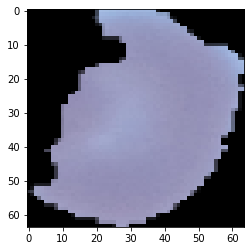

In [28]:
randn = random.randint(0,79)
index = randn
X_train = X_train_org/255.
X_test = X_test_org/255.
Y_train = convert_to_one_hot(Y_test_org,2).T
Y_test = convert_to_one_hot(Y_test_org,2).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}
plt.imshow(X_train[index])

# FITTING THE MODEL

Fitting the defined Resnet model to classify the images with given data.

Epochs are <5 because the model is so large that it nearly consists more than million parameters.

In [29]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
50/50 [==============================] - 25s 504ms/step - loss: 9.0765 - accuracy: 0.5400
Epoch 2/2
50/50 [==============================] - 1s 22ms/step - loss: 10.6072 - accuracy: 0.5400


# PREDICTING THE RESULTS

In [30]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

50/50 [==============================] - 2s 48ms/step
Loss = 9.411562042236328
Test Accuracy = 0.4000000059604645


In [31]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

50/50 [==============================] - 0s 5ms/step
Loss = 9.411562042236328
Test Accuracy = 0.4000000059604645


# FUNCTION FOR PREDICTING THE CLASS OF THE IMAGE

The below function takes the image path as input and returns the predicted output

In [36]:
def predict(pathofimg):
    img_path = pathofimg
    imga = cv2.imread(img_path)
    img = cv2.resize(imga,(64,64))
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    print('Input image shape:', x.shape)
    my_image = cv2.imread(img_path)
    imshow(my_image)
    s = f"class prediction vector p(0), p(1)={model.predict(x)} "
    return s

Input image shape: (1, 64, 64, 3)


'class prediction vector p(0), p(1)=[[5.0659019e-05 9.9994934e-01]] '

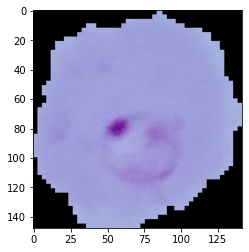

In [37]:
predict('C:/Users/G.VENKATARAMANA/DataSets/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')